In [ ]:
import numpy as np
import pandas as pd 
import os
from itertools import chain
#import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/all_data.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 36 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        180 non-null    int64  
 1   region_name                       180 non-null    object 
 2   country_code                      180 non-null    object 
 3   province_name                     166 non-null    object 
 4   city_name                         180 non-null    object 
 5   region_city_rank                  180 non-null    int64  
 6   latitude                          180 non-null    float64
 7   longitude                         180 non-null    float64
 8   int_visitor_2019 (million)        180 non-null    float64
 9   mountain                          180 non-null    int64  
 10  beach                             180 non-null    int64  
 11  island                            180 non-null    int64  
 12  lake    

In [ ]:
df=pd.DataFrame(data)

### Cleaning the data

In [ ]:
df.columns = df.columns.str.replace(' ', '')

In [ ]:
paragraphs = data[['paragraph']]
print(paragraphs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   paragraph  180 non-null    object
dtypes: object(1)
memory usage: 1.5+ KB
None


In [ ]:
paragraphs.sample(10)

,paragraph
30,\nParis (English: /ˈpærɪs/; French pronunciati...
76,\nScottsdale is a city in the eastern part of ...
32,\nBrussels (French: Bruxelles [bʁysɛl] (listen...
122,Puerto Morelos (Spanish pronunciation: ['pweɾt...
174,\nPune (Marathi: [puɳe] (listen); English: /ˈ...
17,\nGrand Cayman is the largest of the three Cay...
38,"\nBruges (/bruːʒ/ (listen) BROOZH, French: [bʁ..."
148,\nBrisbane (/ˈbrɪzbən/ (listen) BRIZ-bən)[9] i...
173,\nVaranasi (Vārāṇasī; [ʋaːˈraːɳəsi]; also Bana...
125,\nToronto (/təˈrɒntoʊ/ (listen) tə-RON-toh; lo...


In [ ]:
text_data=paragraphs['paragraph'].values.tolist()

In [ ]:
import re
text_data=[re.sub(r'[^A-Za-z\s]','',text) for text in text_data] 

In [ ]:
from pprint import pprint
pprint(len(text_data[0]))

print(text_data[0:3])

89545
['\nCaput Mundi\xa0LatinThe Capital of the world\nRome Italian and Latin Roma roma listen is the capital city of Italy It is also the capital of the Lazio region the centre of the Metropolitan City of Rome and a special comune named Comune di Roma Capitale With  residents in \xa0km \xa0sq\xa0mi Rome is the countrys most populated comune and the third most populous city in the European Union by population within city limits The Metropolitan City of Rome with a population of  residents is the most populous metropolitan city in Italy Its metropolitan area is the thirdmost populous within Italy Rome is located in the centralwestern portion of the Italian Peninsula within Lazio Latium along the shores of the Tiber Vatican City the smallest country in the world is an independent country inside the city boundaries of Rome the only existing example of a country within a city Rome is often referred to as the City of Seven Hills due to its geographic location and also as the Eternal City R

In [ ]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(texts):
    for text in texts:
        yield(simple_preprocess(str(text),deacc=True))
        
data_words=list(sent_to_words(text_data))

In [ ]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
new_stopwords = ['city','area','large','population','year','many','first','home','high','centre','century','mile','major']
stopword.extend(new_stopwords)

def remove_stopwords(texts):
    return [[word for word in text if word not in stopword] for text in texts]

data_words_nostops=remove_stopwords(data_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import gensim

bigram=gensim.models.Phrases(data_words_nostops,min_count=5,threshold=100)
trigram=gensim.models.Phrases(bigram[data_words_nostops],threshold=100)

bigram_mod=gensim.models.phrases.Phraser(bigram)

def make_bigram(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_nostops_bigrams=make_bigram(data_words_nostops)

In [ ]:
import spacy
nlp=spacy.load("en_core_web_sm",disable=['parser','ner'])

def lemmatize(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_lemmatized=lemmatize(data_words_nostops_bigrams,allowed_postags=['NOUN'] )

### LDA

In [ ]:
import gensim.corpora as corpora
id2word=corpora.Dictionary(data_lemmatized)
texts=data_lemmatized
corpus=[id2word.doc2bow(text) for text in texts]

In [ ]:
print([[(id2word[id],freq) for (id,freq) in cp]for cp in corpus[:2]])

[[('abdication', 2), ('absence', 1), ('academy', 3), ('acceptance', 1), ('access', 1), ('accumulation', 1), ('activity', 4), ('actor', 2), ('actress', 1), ('ad', 17), ('addition', 1), ('administration', 4), ('aequi', 1), ('aerospace', 1), ('affair', 1), ('age', 7), ('agency', 4), ('aggregation', 2), ('agriculture', 1), ('airport', 6), ('albornoz', 2), ('alla', 2), ('ally', 1), ('altitude', 1), ('ambassador', 1), ('among_other', 1), ('amount', 2), ('amphitheatre', 2), ('anagni', 1), ('ancient_greek', 1), ('angel', 1), ('aniene', 1), ('annalist', 1), ('antiquity', 5), ('antonine', 3), ('antony', 1), ('anulare', 1), ('apartment', 1), ('apostle', 2), ('appearance', 1), ('approach', 1), ('aqueduct', 3), ('arab', 1), ('arbitrator', 2), ('archaeological_evidence', 2), ('architect', 4), ('architecture', 15), ('area', 14), ('argument', 2), ('aristocracy', 2), ('aristocrat', 3), ('army', 3), ('arnaldo', 1), ('arrival', 1), ('art', 16), ('art_gallerie', 1), ('artichoke', 1), ('artist', 5), ('artw

In [ ]:
#Modelleme kısmı
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=15,random_state=100,update_every=1,
                                         chunksize=100,passes=10,alpha='auto',per_word_topics=True)


pprint(lda_model.print_topics())

doc_lda=lda_model[corpus]

[(0,
  '0.042*"island" + 0.034*"virginia_beach" + 0.023*"boracay" + 0.009*"minh" + '
  '0.006*"tourism" + 0.004*"hampton_road" + 0.004*"beach" + 0.003*"vietnam" + '
  '0.002*"depression" + 0.002*"cayman_island"'),
 (1,
  '0.011*"park" + 0.011*"school" + 0.008*"world" + 0.008*"city" + '
  '0.007*"district" + 0.007*"service" + 0.006*"building" + 0.006*"system" + '
  '0.006*"station" + 0.005*"part"'),
 (2,
  '0.008*"school" + 0.008*"people" + 0.008*"town" + 0.007*"district" + '
  '0.007*"service" + 0.007*"park" + 0.006*"city" + 0.006*"area" + 0.006*"part" '
  '+ 0.006*"government"'),
 (3,
  '0.029*"mumbai" + 0.023*"lago" + 0.017*"island" + 0.012*"state" + '
  '0.010*"barbado" + 0.010*"government" + 0.009*"tampa" + 0.007*"hong_kong" + '
  '0.007*"world" + 0.007*"port"'),
 (4,
  '0.020*"venice" + 0.013*"bruge" + 0.012*"miami_beach" + 0.011*"benidorm" + '
  '0.011*"carman" + 0.010*"las_vegas" + 0.010*"island" + 0.008*"lagoon" + '
  '0.007*"cruise_ship" + 0.006*"tourist"'),
 (5,
  '0.002*"sed

In [ ]:
print(list(doc_lda)[0])

([(1, 0.041378494), (2, 0.071336426), (3, 0.013675836), (11, 0.37105876), (12, 0.5024785)], [(0, [11]), (1, [12, 1, 2]), (2, [11, 12, 1, 2]), (3, [12, 1, 3]), (4, [12, 2, 1]), (5, [11, 12, 2, 1]), (6, [12, 11, 2, 1, 3]), (7, [11, 12, 2, 1]), (8, [11, 12, 1, 2]), (9, [11, 12, 1, 2]), (10, [12, 11, 2, 1]), (11, [12, 2, 3, 1, 11]), (12, []), (13, [12, 2, 1]), (14, [12, 2]), (15, [11, 12, 2, 1]), (16, [12, 2, 1, 3]), (17, [11]), (18, [12, 2, 1]), (19, [12, 11, 2, 1, 3]), (20, [11]), (21, [11, 12]), (22, [12, 2, 1]), (23, [12, 11, 2]), (24, [12, 11, 2, 1]), (25, [11, 2]), (26, [11, 12, 2, 1]), (27, [2, 3]), (28, []), (29, [11, 12]), (30, [2, 1]), (31, []), (32, []), (33, [11, 12, 1]), (34, [11, 12]), (35, []), (36, [11]), (37, [12, 2, 1]), (38, [12]), (39, [11, 12, 2, 1, 3]), (40, [2, 1]), (41, [11, 12, 2, 3]), (42, [3]), (43, [11]), (44, [11, 2]), (45, [12, 11, 2, 1]), (46, [12, 11, 1, 2, 3]), (47, [12, 2, 1, 11, 3]), (48, [11, 1]), (49, [11, 12]), (50, [11]), (51, [11, 12, 2, 1, 3]), (52,

In [ ]:
print(lda_model[corpus[0]])
print("*****************")
print("The Topics Distribution for first doc: ")
print(lda_model[corpus[0]][0])

([(1, 0.041345213), (2, 0.07137578), (3, 0.01367566), (11, 0.37105933), (12, 0.50247204)], [(0, [11]), (1, [12, 1, 2]), (2, [11, 12, 1, 2]), (3, [12, 1, 3]), (4, [12, 2, 1]), (5, [11, 12, 2, 1]), (6, [12, 11, 2, 1, 3]), (7, [11, 12, 2, 1]), (8, [11, 12, 1, 2]), (9, [11, 12, 1, 2]), (10, [12, 11, 2, 1]), (11, [12, 2, 3, 1, 11]), (12, []), (13, [12, 2, 1]), (14, [12, 2]), (15, [11, 12, 2, 1]), (16, [12, 2, 1, 3]), (17, [11]), (18, [12, 2, 1]), (19, [12, 11, 2, 1, 3]), (20, [11]), (21, [11, 12]), (22, [12, 2, 1]), (23, [12, 11, 2]), (24, [12, 11, 2, 1]), (25, [11, 2]), (26, [11, 12, 2, 1]), (27, [2, 3]), (28, []), (29, [11, 12]), (30, [2, 1]), (31, []), (32, []), (33, [11, 12, 1]), (34, [11, 12]), (35, []), (36, [11]), (37, [12, 2, 1]), (38, [12]), (39, [11, 12, 2, 1, 3]), (40, [2, 1]), (41, [11, 12, 2, 3]), (42, [3]), (43, [11]), (44, [11, 2]), (45, [12, 11, 2, 1]), (46, [12, 11, 1, 2, 3]), (47, [12, 2, 1, 11, 3]), (48, [11, 1]), (49, [11, 12]), (50, [11]), (51, [11, 12, 2, 1, 3]), (52, 

In [ ]:
print("Perplexity: ",lda_model.log_perplexity(corpus))

from gensim.models import CoherenceModel
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_lemmatized,dictionary=id2word,coherence='c_v')

coherence_lda=coherence_model_lda.get_coherence()
print('Coherence Score: ',coherence_lda)

Perplexity:  -8.909185958185335
Coherence Score:  0.3931094518860672


In [ ]:
# Assigns the topics to the documents in corpus
lda_corpus = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#[doc for doc in lda_corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Search for optimal number of topics
ntopics = list(range(1,16))

metrics = pd.DataFrame({'topics':ntopics,'Perplexity':[0.0]*len(ntopics) ,'UMASS':[0.0]*len(ntopics),'UCI':[0.0]*len(ntopics),'NPMI':[0.0]*len(ntopics)})


for t in range(len(ntopics)):
  lda_model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=ntopics[t],
                                        chunksize=10000,
                                        random_state=100,
                                        passes=15,
                                        iterations=500,
                                        alpha='auto',
                                        eta="auto",
                                        eval_every=None)
  print("N.topic:",ntopics[t], "DONE")
      

  metrics["Perplexity"][t] = lda_model.log_perplexity(corpus)
  metrics["UMASS"][t] = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="u_mass").get_coherence()
  metrics["UCI"][t] = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_uci").get_coherence()
  metrics["NPMI"][t] = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="c_npmi").get_coherence()
      

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


N.topic: 1 DONE


<ipython-input-115-acb8abfd2f85>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["Perplexity"][t] = lda_model.log_perplexity(corpus)
<ipython-input-115-acb8abfd2f85>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["UMASS"][t] = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence="u_mass").get_coherence()
<ipython-input-115-acb8abfd2f85>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

N.topic: 2 DONE


N.topic: 3 DONE


N.topic: 4 DONE
N.topic: 5 DONE
N.topic: 6 DONE
N.topic: 7 DONE
N.topic: 8 DONE
N.topic: 9 DONE
N.topic: 10 DONE
N.topic: 11 DONE
N.topic: 12 DONE
N.topic: 13 DONE
N.topic: 14 DONE
N.topic: 15 DONE


In [ ]:
metrics.to_csv("metric_lda.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topics,Perplexity,UMASS,UCI,NPMI
0,1,-7.977856,-0.069186,-0.172617,-0.022158
1,2,-7.980528,-0.220104,-0.174120,-0.017074
2,3,-7.986814,-1.725226,-1.284248,-0.050609
3,4,-7.975783,-1.303860,-0.995702,-0.041694
4,5,-7.982755,-0.996876,-0.849215,-0.037153
5,6,-8.009625,-2.429062,-2.161902,-0.080292
6,7,-8.014198,-1.909053,-1.759779,-0.062542
7,8,-8.019952,-2.027832,-1.908733,-0.067942
8,9,-8.023204,-2.099443,-2.042930,-0.073024
9,10,-8.027772,-1.600289,-1.901725,-0.069490


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


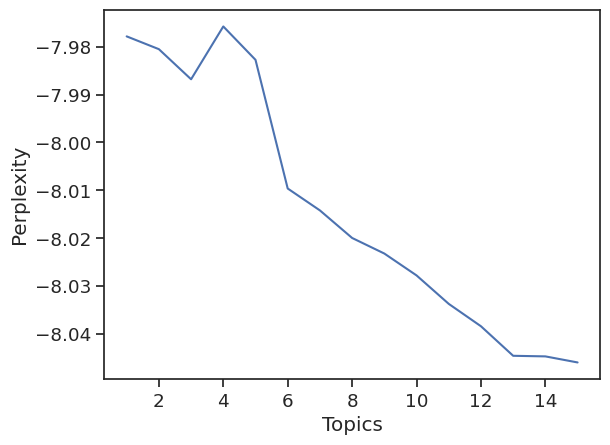

In [ ]:
# Perplexity
plt.plot(metrics["topics"],metrics["Perplexity"])
plt.xlabel("Topics")
plt.ylabel("Perplexity")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


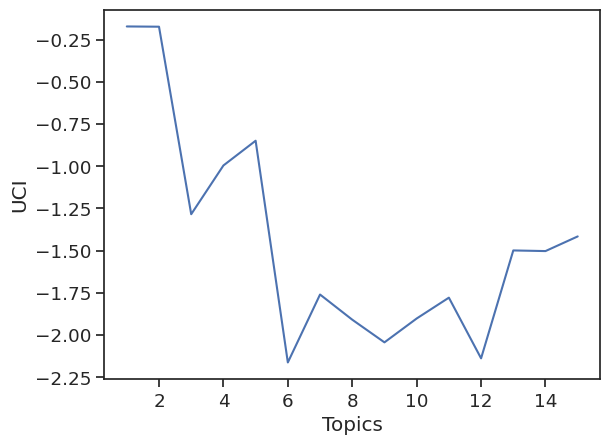

In [ ]:
# UCI
plt.plot(metrics["topics"],metrics["UCI"])
plt.xlabel("Topics")
plt.ylabel("UCI")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


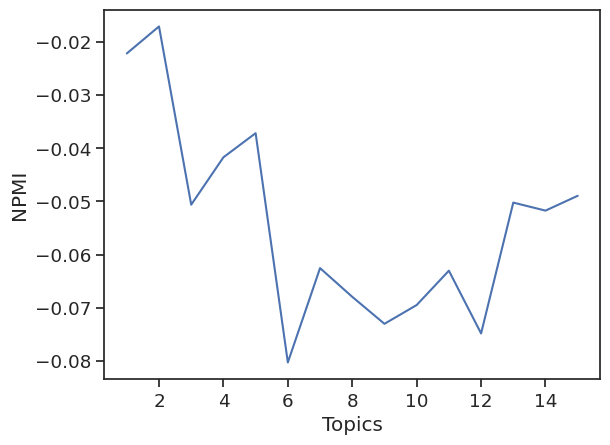

In [ ]:
# NPMI
plt.plot(metrics["topics"],metrics["NPMI"])
plt.xlabel("Topics")
plt.ylabel("NPMI")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


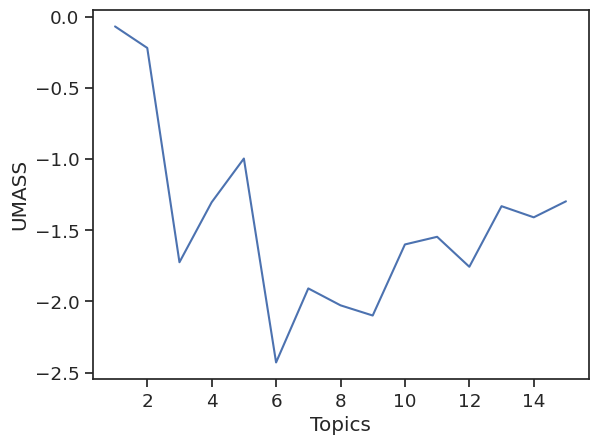

In [ ]:
# C_umass
plt.plot(metrics["topics"],metrics["UMASS"])
plt.xlabel("Topics")
plt.ylabel("UMASS")
plt.show()

In [ ]:
# number of topics
num_topics = 15
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics,
                                    random_state=100,
                                    chunksize=10000,
                                    passes=15,
                                    iterations=500,
                                    alpha='auto',
                                    eta="auto",
                                    eval_every=None)    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("Perplexity:",lda_model.log_perplexity(corpus))
print("CM (u_mass):",gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence="u_mass").get_coherence())
print("CM (uci):",gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence="c_uci").get_coherence())
print("CM (u_npmi):",gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence="c_npmi").get_coherence())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity: -8.045946073961607
CM (u_mass): -1.2973338497560778
CM (uci): -1.4157717092919948
CM (u_npmi): -0.048935327002589214


### Results visualization

In [ ]:
from wordcloud import WordCloud

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cm

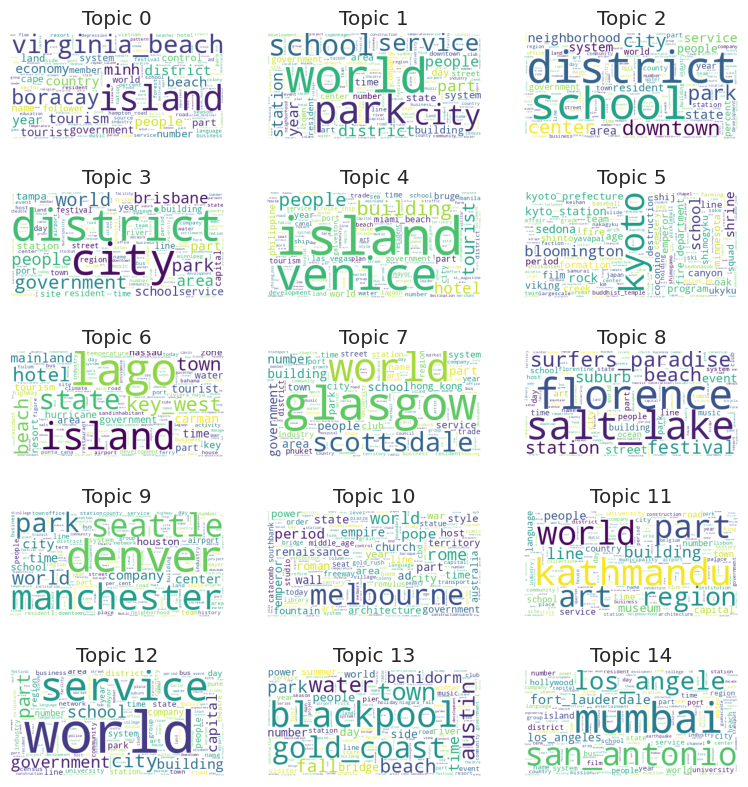

In [ ]:
fig, ax = plt.subplots(5, 3, figsize=(9.4, 10))
t = 0
for i in range(5):
    for j in range(3):
        ax[i, j].imshow(WordCloud(background_color="white", max_words=500).fit_words(dict(lda_model.show_topic(t, 500))))
        ax[i, j].set_title("Topic {}".format(t))
        ax[i, j].axis("off")
        t += 1

plt.savefig("lda_wc.pdf", dpi=300)
plt.show(fig)

In [ ]:
def assign_topic(model,docs):
  docs_tuples = model.get_document_topics(docs,minimum_probability=0)
  topic_docs = [0]*len(docs_tuples)
  max_prob_docs = [0]*len(docs_tuples)
  for n in range(len(docs_tuples)):
    doc_tuples = docs_tuples[n]
    doc_probs = [0]*model.num_topics
    for i in range(model.num_topics):
      doc_probs[i] = doc_tuples[i][1]
    
    topic = np.argmax(doc_probs)
    prob = np.max(doc_probs)
    topic_docs[n] = topic
    max_prob_docs[n] = prob
  
  return topic_docs, max_prob_docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def assign_multitopic(model,docs,threshold = 0.25):
  topic_prob = model.get_document_topics(docs,minimum_probability=0)
  topic_docs = [0]*len(topic_prob)
  for n in range(len(topic_prob)):
    doc = topic_prob[n]
    probs = [0]*model.num_topics
    for i in range(model.num_topics):
      probs[i] = doc[i][1]
    
    topic_list = [i for i in range(model.num_topics) if probs[i]>threshold]
    topic_docs[n] = topic_list
  
  return topic_docs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_docs,prob_docs = assign_topic(lda_model,corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topic_docs[0:16]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[10, 12, 3, 12, 8, 11, 11, 4, 8, 13, 6, 6, 9, 4, 11, 2]

In [ ]:
multitopics_docs = assign_multitopic(lda_model,corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
multitopics_docs[0:16]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[10, 11],
 [12],
 [3],
 [12],
 [8, 11],
 [11],
 [7, 11],
 [4],
 [8],
 [13],
 [2, 6],
 [2, 6],
 [2, 9],
 [4],
 [11],
 [2]]

In [ ]:
df["Topic"] = topic_docs
df["pTopic"] = prob_docs
df["MultiTopic"] = multitopics_docs
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed:0,region_name,country_code,province_name,city_name,region_city_rank,latitude,longitude,int_visitor_2019(million),mountain,...,Dec-FebAvgTemp(°F),Jun-AugAvgTemp(°F),NearUNESCOWorldHeritageSite?,about_title,about_content,30_attractions_char,paragraph,Topic,pTopic,MultiTopic
0,0,SOUTHERN EUROPE,IT,LAZIO,ROME,1,41.893320,12.482932,22.5,1,...,50,77,1,About Rome,"All roads lead to Rome, so they say. Or maybe ...","['Historic Sites • Ancient Ruins', 'Ancient Ru...",\nCaput Mundi (Latin)The Capital of the world\...,10,0.547256,"[10, 11]"
1,1,SOUTHERN EUROPE,SP,CATALONIA,BARCELONA,2,41.382894,2.177432,9.1,1,...,51,78,1,"Perfect beaches, world-famous tapas, and Gaudí...",There’s nowhere in the world like Barcelona. F...,['Points of Interest & Landmarks • Architectur...,\nBarcelona (/ˌbɑːrsəˈloʊnə/ (listen) BAR-sə-L...,12,0.955485,[12]
2,2,SOUTHERN EUROPE,TU,ISTANBUL,ISTANBUL,3,41.009198,28.966219,14.7,1,...,46,75,1,A spellbinding city where cultures collide,"Over the centuries, many cultures have added t...","['Historic Sites • Architectural Buildings', '...","\nIstanbul (/ˌɪstænˈbʊl/ IST-an-BUUL,[7][8] US...",3,0.999867,[3]
3,3,SOUTHERN EUROPE,IT,LOMBARDIA,MILAN,4,45.464194,9.189635,6.5,1,...,38,77,0,About Milan,If you skip Milan in favor of Italy’s more pop...,"['Religious Sites • Churches & Cathedrals', 'P...","\nMilan (/mɪˈlæn/ mil-AN, US also /mɪˈlɑːn/ mi...",12,0.797448,[12]
4,4,SOUTHERN EUROPE,IT,TOSCANA (TUSCANY),FLORENCE,5,43.769871,11.255576,10.4,1,...,43,81,1,"A wonderland of art and architecture, all fuel...",Florence makes art-lovers' hearts beat double ...,"['Points of Interest & Landmarks', 'Art Museum...",\nFlorence (/ˈflɒrəns/ FLORR-ənss; Italian: Fi...,8,0.671913,"[8, 11]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,NORTHEAST ASIA,KR,SEOUL,SEOUL,1,37.566679,126.978291,15.4,0,...,25,77,1,"The business and cultural hub of South Korea, ...",From modern skyscrapers and neon lights to Bud...,"['Historic Sites • History Museums', 'Public T...",\nSeoul (/soʊl/; Korean: [sʰʌul] (listen); lit...,12,0.740552,"[9, 12]"
176,176,NORTHEAST ASIA,KR,SOUTH GYEONGSANG,BUSAN,2,35.179953,129.075236,6.4,1,...,36,79,0,About Busan,Busan is Korea's second largest city. Tourist...,"['Neighborhoods • Flea & Street Markets', 'Bea...","\nBusan (Korean pronunciation: [pu.sa̠n]), off...",3,0.999661,[3]
177,177,NORTHEAST ASIA,JP,KANTO,TOKYO,3,35.681266,139.757653,14.1,1,...,41,77,1,About Tokyo,"After a pair of quiet years, Japan has reopene...","['Religious Sites', 'Gardens', 'Points of Inte...","\nTokyo (/ˈtoʊkioʊ/;[7] Japanese: 東京, Tōkyō, [...",3,0.999714,[3]
178,178,NORTHEAST ASIA,JP,KANSAI,KYOTO,4,35.021041,135.755607,4.4,1,...,39,79,1,"A passageway to Japan's past, full of World He...",The shrines and temples of Kyoto offer a rare ...,"['Historic Sites • Religious Sites', 'Religiou...","Kyoto (/ˈkjoʊtoʊ/;[3] Japanese: 京都, Kyōto [kʲo...",12,0.628841,"[5, 12]"


In [ ]:
df.groupby("Topic").count().iloc[:,0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic
0      3
1     33
2     46
3     18
4     10
6      9
7     10
8      5
9      4
10     1
11     7
12    27
13     4
14     3
Name: Unnamed:0, dtype: int64

In [ ]:
grouped_df = df.groupby('Topic')['city_name'].apply(list).reset_index(name='Cities')
grouped_df['Count'] = grouped_df['Cities'].apply(len)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
grouped_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Cities,Count
0,0,"[SAINT LUCIA, GRAND CAYMAN, BORACAY]",3
1,1,"[SINGAPORE, COPENHAGEN, MUNICH, ZURICH, NEW YO...",33
2,2,"[BARBADOS, BANGKOK, TAIPEI, PARIS, LAS VEGAS, ...",46
3,3,"[ISTANBUL, PUERTO PLATA, NEW ORLEANS, TAMPA, S...",18
4,4,"[VENICE, PALM BEACH, PROVIDENCIALES, MANILA, C...",10
5,6,"[PUNTA CANA, NASSAU, KEY WEST, CLEARWATER BEAC...",9
6,7,"[PHUKET, HONG KONG, AMSTERDAM, SCOTTSDALE, FOR...",10
7,8,"[FLORENCE, ATHENS, SALT LAKE CITY, OCEAN CITY,...",5
8,9,"[MONTEGO BAY, SEATTLE, DENVER, MANCHESTER]",4
9,10,[ROME],1
